In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.8/dist-packages/tensorflow/_api/v2/version/__init__.py'>

# PREPROCESSING

Read IBM stock OHLC ( open, high, low, close) and S&P 500 bid/ask data. data into pandas dataframe.

In [ ]:

df_hdfc = pd.read_csv('/content/drive/MyDrive/ASIANPAINT.csv')

#df_hdfc.columns = ["Date","Open", "High", "Low", "Last", "Close", "Volume", "turnover"]
#df_hdfc = df_hdfc.drop(columns=['Last', 'Volume'])

df_hdfc.head()

,Date,Open,High,Low,Last,Close,Volume
0,03-01-2000,370.0,390.0,370.0,385.0,381.65,3318
1,04-01-2000,380.0,392.0,375.0,390.0,385.55,4818
2,05-01-2000,371.5,390.0,371.5,383.0,383.00,2628
3,06-01-2000,384.9,384.9,374.5,375.1,377.50,3354
4,07-01-2000,376.0,390.0,370.0,389.0,385.70,9589


In [ ]:
df_hdfc.tail()

,Date,Open,High,Low,Last,Close,Volume
5301,26-04-2021,2530.0,2575.00,2530.00,2558.0,2557.90,1103980
5302,27-04-2021,2545.0,2579.90,2534.00,2571.0,2574.35,866331
5303,28-04-2021,2588.0,2620.25,2575.00,2612.0,2614.55,1065561
5304,29-04-2021,2630.0,2642.00,2570.00,2613.0,2613.45,1295346
5305,30-04-2021,2595.0,2605.80,2524.05,2529.0,2536.40,1384907


Transform Bid/Ask data to OHLC format by taking average of both low and high counterparts.

In [ ]:
df_hdfc.shape       

(5306, 7)

**Create training data**

In [ ]:
df = df_hdfc


In [ ]:

df.head()

,Date,Open,High,Low,Last,Close,Volume
0,03-01-2000,370.0,390.0,370.0,385.0,381.65,3318
1,04-01-2000,380.0,392.0,375.0,390.0,385.55,4818
2,05-01-2000,371.5,390.0,371.5,383.0,383.00,2628
3,06-01-2000,384.9,384.9,374.5,375.1,377.50,3354
4,07-01-2000,376.0,390.0,370.0,389.0,385.70,9589


In [ ]:
df_hdfc.drop([0], axis=0,inplace = True)

df_hdfc

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], yearfirst=True)
df_hdfc.set_index('Date')
df.set_index('Date')

,Open,High,Low,Last,Close,Volume
Date,,,,,,
2000-04-01,380.0,392.00,375.00,390.0,385.55,4818
2000-05-01,371.5,390.00,371.50,383.0,383.00,2628
2000-06-01,384.9,384.90,374.50,375.1,377.50,3354
2000-07-01,376.0,390.00,370.00,389.0,385.70,9589
2000-10-01,415.0,416.60,409.00,416.6,415.00,60313
...,...,...,...,...,...,...
2021-04-26,2530.0,2575.00,2530.00,2558.0,2557.90,1103980
2021-04-27,2545.0,2579.90,2534.00,2571.0,2574.35,866331
2021-04-28,2588.0,2620.25,2575.00,2612.0,2614.55,1065561


In [ ]:
df_concat = df_hdfc.dropna()

In [ ]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Last             float64
Close            float64
Volume             int64
dtype: object

In [ ]:
df['Close'] = pd.to_numeric(df['Close'])
df['High'] = pd.to_numeric(df['High'])
df['Low'] = pd.to_numeric(df['Low'])
df['Open'] = pd.to_numeric(df['Open'])


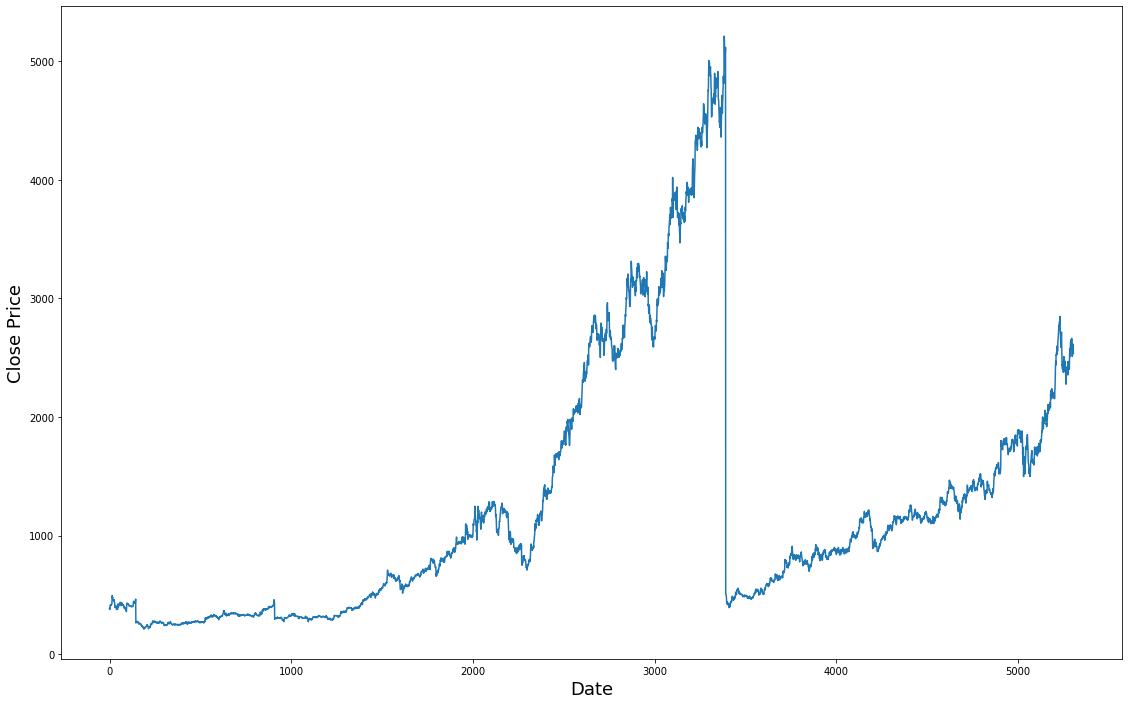

In [ ]:
plt.figure(figsize = (19,12))
plt.plot(range(df.shape[0]),(df['Close']))
#plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price',fontsize=18)
plt.show()

In [ ]:
df_concat.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Last             float64
Close            float64
Volume             int64
dtype: object

In [ ]:
SEQ_LEN = 100            

FUTURE_PERIOD = 1

RATIO_TO_PREDICT = "Close"


In [ ]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [ ]:
df = df.drop("Date", axis= 1)

Splitting the data

In [ ]:
times = sorted(df.index.values)  # get the times
last_10 = sorted(df.index.values)[-int(0.1*len(times))] 
last_20 = sorted(df.index.values)[-int(0.2*len(times))]

test_df = df[(df.index >= last_10)]
validation_df = df[(df.index >= last_20) & (df.index < last_10)]  
train_df = df[(df.index < last_20)] 

In [ ]:
from collections import deque
import numpy as np
import random 

In [ ]:

train_ = train_df.values
valid_ = validation_df.values
test_ = test_df.values

In [ ]:
print("train shape {0}".format(train_.shape))
print("valid shape {0}".format(valid_.shape))
print("test shape {0}".format(test_.shape))

train shape (4244, 6)
valid shape (531, 6)
test shape (530, 6)


In [ ]:
scaler = MinMaxScaler()
scale_close = MinMaxScaler()
scalernew=MinMaxScaler(feature_range=(0,1))


In [ ]:
x = train_[:,3].copy()
scale_close.fit(x.reshape(-1, 1))

MinMaxScaler()

In [ ]:
scaler.fit(train_)

train_ = scaler.transform(train_)

valid_ = scaler.transform(valid_)
test_ = scaler.transform(test_)

EMA --- Exponential Moving Average


In [ ]:
EMA = 0.0
gamma = 0.1
for ti in range(3669):
    EMA = gamma*train_[ti] + (1-gamma)*EMA
    train_[ti] = EMA

all_mid_data = np.concatenate([train_,valid_, test_],axis=0)

100 timesteps 


In [ ]:
def split_data(data):
    X = []
    Y = []
    for i in range(SEQ_LEN, len(data)-FUTURE_PERIOD+1):
        X.append(data[i-SEQ_LEN:i])
        Y.append(data[i+(FUTURE_PERIOD-1), 3])
    return np.array(X), np.array(Y)

In [ ]:
X_train, y_train = split_data(train_)
X_test, y_test = split_data(test_)
X_valid, y_valid = split_data(valid_)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 6))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

In [ ]:
y_train.shape

(4144,)

In [ ]:
print("train shape {0}".format(X_train.shape))
print("valid shape {0}".format(X_valid.shape))
print("test shape {0}".format(X_test.shape))

train shape (4144, 100, 6)
valid shape (431, 100, 6)
test shape (430, 100, 6)


In [ ]:
X_train_2, y_train_2 = split_data(train_)
X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], X_train_2.shape[1], 6))

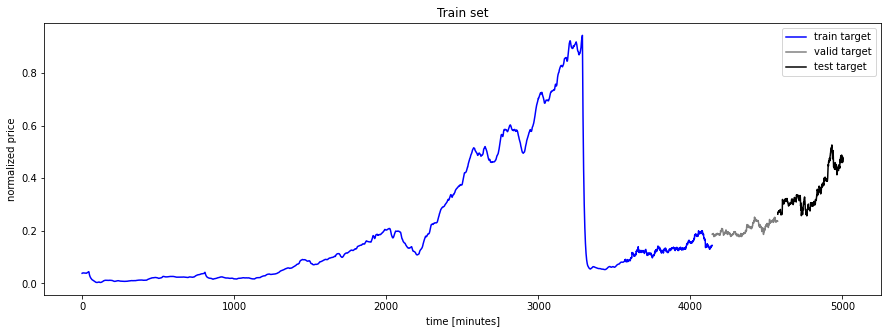

In [ ]:
## show predictions
plt.figure(figsize=(15, 5))

plt.plot(np.arange(y_train_2.shape[0]), y_train_2, color='blue', label='train target')

plt.plot(np.arange(y_train_2.shape[0], y_train_2.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train_2.shape[0]+y_valid.shape[0],
                   y_train_2.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Train set')
plt.xlabel('time [minutes]')
plt.ylabel('normalized price')
plt.legend(loc='best');

# TRANSFORMER

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [ ]:
EPOCHS = 65
BATCH_SIZE = 64

import time

In [ ]:
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers import Layer

In [ ]:
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape


In [ ]:
class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

In [ ]:
class MultiHeadAttention():

    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        self.qs_layer = Dense(n_head*d_k, use_bias=False)
        self.ks_layer = Dense(n_head*d_k, use_bias=False)
        self.vs_layer = Dense(n_head*d_v, use_bias=False)
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

In [ ]:
class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

    
class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn
    
    
def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

In [ ]:
class CustomeLearningSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomeLearningSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        param_1 = tf.math.rsqrt(step)
        param_2 = step * (self.warmup_steps**(-1.5))
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(param_1, param_2)


Text(0.5, 0, 'Train Step')

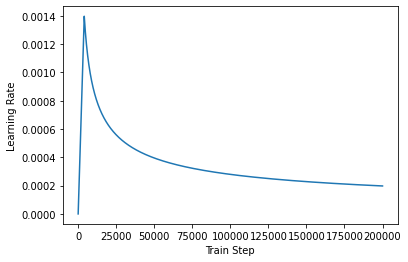

In [ ]:
sample_learning_rate = CustomeLearningSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


In [ ]:
D_MODEL=300

lr = CustomeLearningSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
def build_model():
    inp = Input(shape = (SEQ_LEN, 6))

    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    #for i in range(2):
    x, self_attn = EncoderLayer(
            d_model=D_MODEL,
            d_inner_hid=512, 
            n_head=4, 
            d_k=64,
            d_v=64, 
            dropout=0.2)(x)
        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(128, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)      

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error",  
        optimizer = optimizer)
    
    return model

In [ ]:
multi_head = build_model()
#multi_head.summary()


In [ ]:
#tf.keras.utils.plot_model(multi_head, 
 #                         to_file="multi_head_net.png", 
#                          show_shapes=True)


In [ ]:
#callback = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

In [ ]:
history = multi_head.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_valid, y_valid), )


Epoch 1/65
65/65 [==============================] - 18s 65ms/step - loss: 0.1406 - val_loss: 0.0396
Epoch 2/65
65/65 [==============================] - 3s 41ms/step - loss: 0.0157 - val_loss: 0.0261
Epoch 3/65
65/65 [==============================] - 3s 41ms/step - loss: 0.0077 - val_loss: 0.0366
Epoch 4/65
65/65 [==============================] - 3s 41ms/step - loss: 0.0067 - val_loss: 0.0334
Epoch 5/65
65/65 [==============================] - 3s 41ms/step - loss: 0.0050 - val_loss: 0.0321
Epoch 6/65
65/65 [==============================] - 3s 41ms/step - loss: 0.0034 - val_loss: 0.0423
Epoch 7/65
65/65 [==============================] - 3s 41ms/step - loss: 0.0035 - val_loss: 0.0196
Epoch 8/65
65/65 [==============================] - 3s 41ms/step - loss: 0.0028 - val_loss: 0.0227
Epoch 9/65
65/65 [==============================] - 3s 41ms/step - loss: 0.0022 - val_loss: 0.0137
Epoch 10/65
65/65 [==============================] - 3s 41ms/step - loss: 0.0017 - val_loss: 0.0062
Epoch 11

In [ ]:
multi_head.save_weights('./checkpoints/final_checkpoint_1')


In [ ]:
multi_head.load_weights('./checkpoints/final_checkpoint_1')

In [ ]:
predicted_stock_price_multi_head = multi_head.predict(X_test)
predicted_stock_price_multi_head.shape


14/14 [==============================] - 2s 13ms/step


(430, 1)

In [ ]:
predicted_stock_price = np.vstack((np.full((60,1), np.nan), predicted_stock_price_multi_head))


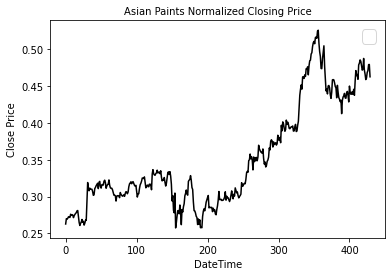

In [ ]:
plt.plot(y_test, color = 'black')
plt.title('ASIAN PAINTS NORMALIZED CLOSING PRICE', fontsize=10)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()


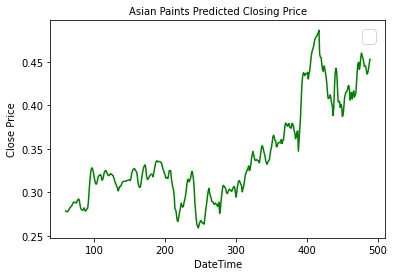

In [ ]:
plt.plot(predicted_stock_price, color = 'green')
plt.title('ASIAN PAINTS PREDICTED CLOSING PRICE', fontsize=10)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.legend(fontsize=18)
plt.show()
